## Data

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
from pathlib import Path

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Data Description

In [2]:
import pandas as pd
data = pd.read_csv('Churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
data.value_counts('Exited')

Exited
0    7963
1    2037
Name: count, dtype: int64

### Preprocessing

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

X = data.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
y = data['Exited']

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)


cat_attribs = ["Geography","Gender"]
num_attribs = X.columns.drop(cat_attribs).to_list()

cat_pipeline = make_pipeline(
    OrdinalEncoder()
)
num_pipeline = make_pipeline(
    # StandardScaler(),
    "passthrough"
)

preprocessing = ColumnTransformer([
    ("cat", cat_pipeline, cat_attribs),
    ("num", num_pipeline, num_attribs),
])

X_train = preprocessing.fit_transform(X_train)

## Decision Tree

In [5]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)

# X_train_decision_tree = preprocessing.transform(X_train)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

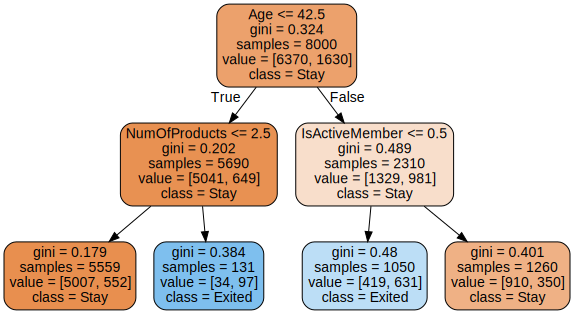

In [6]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=str(IMAGES_PATH / "classification_tree.dot"),  # path differs in the book
        feature_names = cat_attribs + num_attribs,
        class_names=['Stay','Exited'],
        rounded=True,
        filled=True
    )

from graphviz import Source

Source.from_file(IMAGES_PATH / "classification_tree.dot")  

In [7]:
# Predicting the Test set results
X_test = preprocessing.transform(X_test)
y_pred = tree_clf.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[1480  113]
 [ 238  169]]


0.8245

## Ensemble Model

In [8]:
IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

In [9]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [10]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [11]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.7855
rf = 0.862
svc = 0.7965


In [12]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64)]

In [13]:
voting_clf.voting = "soft" # change the default (hard vote) to soft vote
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.8095

### Bagging

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.857125

In [15]:
accuracy_score(y_test, bag_clf.predict(X_test))

0.8575

### Random Forest

In [16]:
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(X_train, y_train)

accuracy_score(y_test, rnd_clf.predict(X_test))

0.861

In [17]:
for score, name in zip(rnd_clf.feature_importances_, cat_attribs + num_attribs):
    print(round(score, 2), name)

0.04 Geography
0.02 Gender
0.14 CreditScore
0.25 Age
0.08 Tenure
0.14 Balance
0.13 NumOfProducts
0.02 HasCrCard
0.04 IsActiveMember
0.15 EstimatedSalary


### AdaBoost

In [18]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

In [19]:
accuracy_score(y_test, ada_clf.predict(X_test))

0.8465

In [20]:
for score, name in zip(ada_clf.feature_importances_, cat_attribs + num_attribs):
    print(round(score, 2), name)

0.17 Geography
0.07 Gender
0.03 CreditScore
0.27 Age
0.0 Tenure
0.07 Balance
0.3 NumOfProducts
0.0 HasCrCard
0.1 IsActiveMember
0.0 EstimatedSalary


### Gradient Boosting

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)

gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [22]:
accuracy_score(y_test, gbrt_best.predict(X_test).round())

0.8525

In [23]:
for score, name in zip(gbrt_best.feature_importances_, cat_attribs + num_attribs):
    print(round(score, 2), name)

0.04 Geography
0.02 Gender
0.01 CreditScore
0.42 Age
0.0 Tenure
0.02 Balance
0.36 NumOfProducts
0.0 HasCrCard
0.14 IsActiveMember
0.0 EstimatedSalary
